## Volatility Targeting backtesting using zipline

* import zipline and other required libraries

In [12]:
import os
import time
import threading
import numpy as np
import pandas as pd
from openbb_terminal.sdk import openbb
import riskfolio as rp

from zipline import run_algorithm
from zipline.api import (
    symbol,
    date_rules,
    time_rules,
    get_datetime,
    schedule_function,
    calendars,
    get_open_orders,
    order_target_percent,
    set_commission,
    set_slippage,
    set_benchmark
)
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.errors import SymbolNotFound

import pyfolio as pf

d:\anaconda3\envs\quant-stack\lib\site-packages\openbb_terminal\stocks\options\tmx_model.py:52: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  options_listings = pd.read_html(r.text)


Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

* Setup Quandl to get data

In [ ]:
from dotenv  import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
NASDAQ_API_KEY = os.getenv("NASDAQ_KEY")

In [8]:
os.environ["QUANDL_API_KEY"] = NASDAQ_API_KEY
bundle = "quandl"
bundles.ingest(bundle)

d:\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:106: FutureWarning: The provided callable <function min at 0x0000028F60D16B80> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
d:\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:106: FutureWarning: The provided callable <function max at 0x0000028F60D16A60> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
d:\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
             open  high   low  close        volume

### Trade Settings

In [9]:
bar_count = 66 # 22 trading days a month * 3
method_mu = "hist"
method_cov = "hist"
lower_ret = 0.0008 # risk free return: 0.08 bps

#### Stock Screening

In [13]:
new_highs = openbb.stocks.screener.screener_data("new_high")
port_data = new_highs[
    (new_highs.Price > 15) &
    (new_highs.Country == "USA")
]

### Initiailize backtest

In [15]:
def initialize(context):
    # from portdata above, get the list of tickers and check if ticker exists in ingested qandl data
    tickers = port_data.Ticker.tolist()
    
    context.assets = []
    for ticker in tickers:
        try:
            context.assets.append(symbol(ticker))
        except SymbolNotFound:
            print(f"{ticker} not found in {bundle} bundle. Skipping...")
    
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )

    # Set up the commission model to charge us per share and a volume slippage model
    set_commission(
        us_equities=commission.PerShare(
            cost=0.005,
            min_trade_cost=2.0
        )
    )
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(
            volume_limit=0.0025, 
            price_impact=0.01
        )
    )
    # set_benchmark(symbol("SPY")) # free data don't have SPY, so manually download and pass it to zipline

In [19]:
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2017-12-31")

import pandas_datareader.data as web
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

### Execute trades

 ##### We loop thru every ticker and if its tradeable and there are no open orders, then we order target percent and zipline rebalances

In [16]:
def exec_trades(data, assets, weights):
    # Loop through every asset...
    for asset in assets:
        # ...if the asset is tradeable and there are no open orders...
        print(asset)
        if data.can_trade(asset) and asset in weights.index and not get_open_orders(asset):
            # ...execute the order against the target percent
            target_percent = weights.at[asset, "weights"]
            order_target_percent(asset, target_percent)

In [18]:
def rebalance(context, data):
    
    assets = context.assets
    
    prices = data.history(
        assets,
        "price",
        bar_count=bar_count,
        frequency="1d"
    )
    
    returns = prices.pct_change()[1:]
    returns.dropna(how="any", axis=1, inplace=True)
    returns = returns.loc[:, (returns != 0).any(axis=0)]
    returns = returns.loc[:, np.isfinite(returns).all(axis=0)]
    
    port = rp.Portfolio(returns=returns)
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
    port.lowerret = lower_ret
    
    # try:
    weights = port.rp_optimization(
        model="Classic",
        rm="MV",
        hist=True,
        rf=0.05,
        b=None
    )
    # except:
    #     print(prices)

    print(
        f"{get_datetime().date()} {context.portfolio.portfolio_value}"
    )

    exec_trades(data, assets=assets, weights=weights)

In [20]:
def analyze(context, perf):
    perf.portfolio_value.plot()

### Run the backtest

VRT not found in quandl bundle. Skipping...
ARCH not found in quandl bundle. Skipping...
STEP not found in quandl bundle. Skipping...
ACU not found in quandl bundle. Skipping...
ONTO not found in quandl bundle. Skipping...
MELI not found in quandl bundle. Skipping...
SLNO not found in quandl bundle. Skipping...
NTNX not found in quandl bundle. Skipping...
ANET not found in quandl bundle. Skipping...
META not found in quandl bundle. Skipping...
HLNE not found in quandl bundle. Skipping...
APO not found in quandl bundle. Skipping...
DT not found in quandl bundle. Skipping...
DDOG not found in quandl bundle. Skipping...
DBX not found in quandl bundle. Skipping...
INSW not found in quandl bundle. Skipping...
GTLB not found in quandl bundle. Skipping...
AMR not found in quandl bundle. Skipping...
FTAI not found in quandl bundle. Skipping...
BKNG not found in quandl bundle. Skipping...
LSXMA not found in quandl bundle. Skipping...
OWL not found in quandl bundle. Skipping...
PSTG not found in

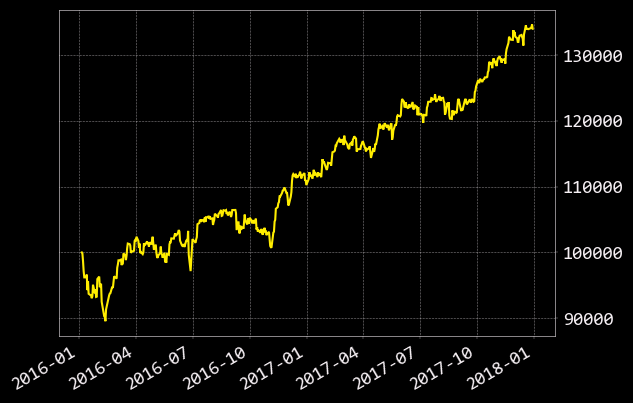

In [21]:
perf = run_algorithm(
    start=pd.Timestamp("2016-01-01"),
    end=pd.Timestamp("2017-12-31"),
    initialize=initialize,
    analyze=analyze,
    capital_base=100_000,
    bundle=bundle,
    benchmark_returns=benchmark_returns,
)

<Axes: >

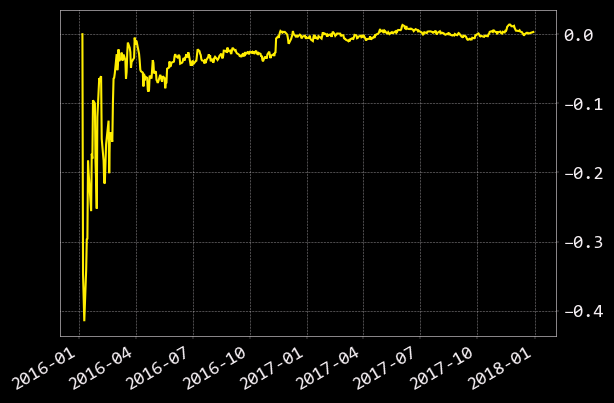

In [22]:
perf.alpha.plot()

In [23]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

Start date,2016-01-04
End date,2017-12-29
Total months,23
,Backtest
Annual return,15.807%
Cumulative returns,34.033%
Annual volatility,11.588%
Sharpe ratio,1.32
Calmar ratio,1.51
Stability,0.96
Max drawdown,-10.463%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.46,2016-01-04,2016-02-11,2016-03-17,54
1,6.04,2016-06-08,2016-06-27,2016-07-08,23
2,5.40,2016-09-07,2016-11-04,2016-11-11,48
3,3.85,2016-04-27,2016-05-19,2016-06-01,26
4,3.03,2017-07-25,2017-08-21,2017-09-27,47


Stress Events,mean,min,max
New Normal,0.06%,-3.50%,2.87%


Top 10 long positions of all time,max
sid,
ERIE,42.05%
ISRG,19.67%
COR,12.40%
MCD,11.30%
KLAC,8.64%
WM,8.06%
AKAM,7.59%
URBN,7.54%
ANF,7.52%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
ERIE,42.05%
ISRG,19.67%
COR,12.40%
MCD,11.30%
KLAC,8.64%
WM,8.06%
AKAM,7.59%
URBN,7.54%
ANF,7.52%


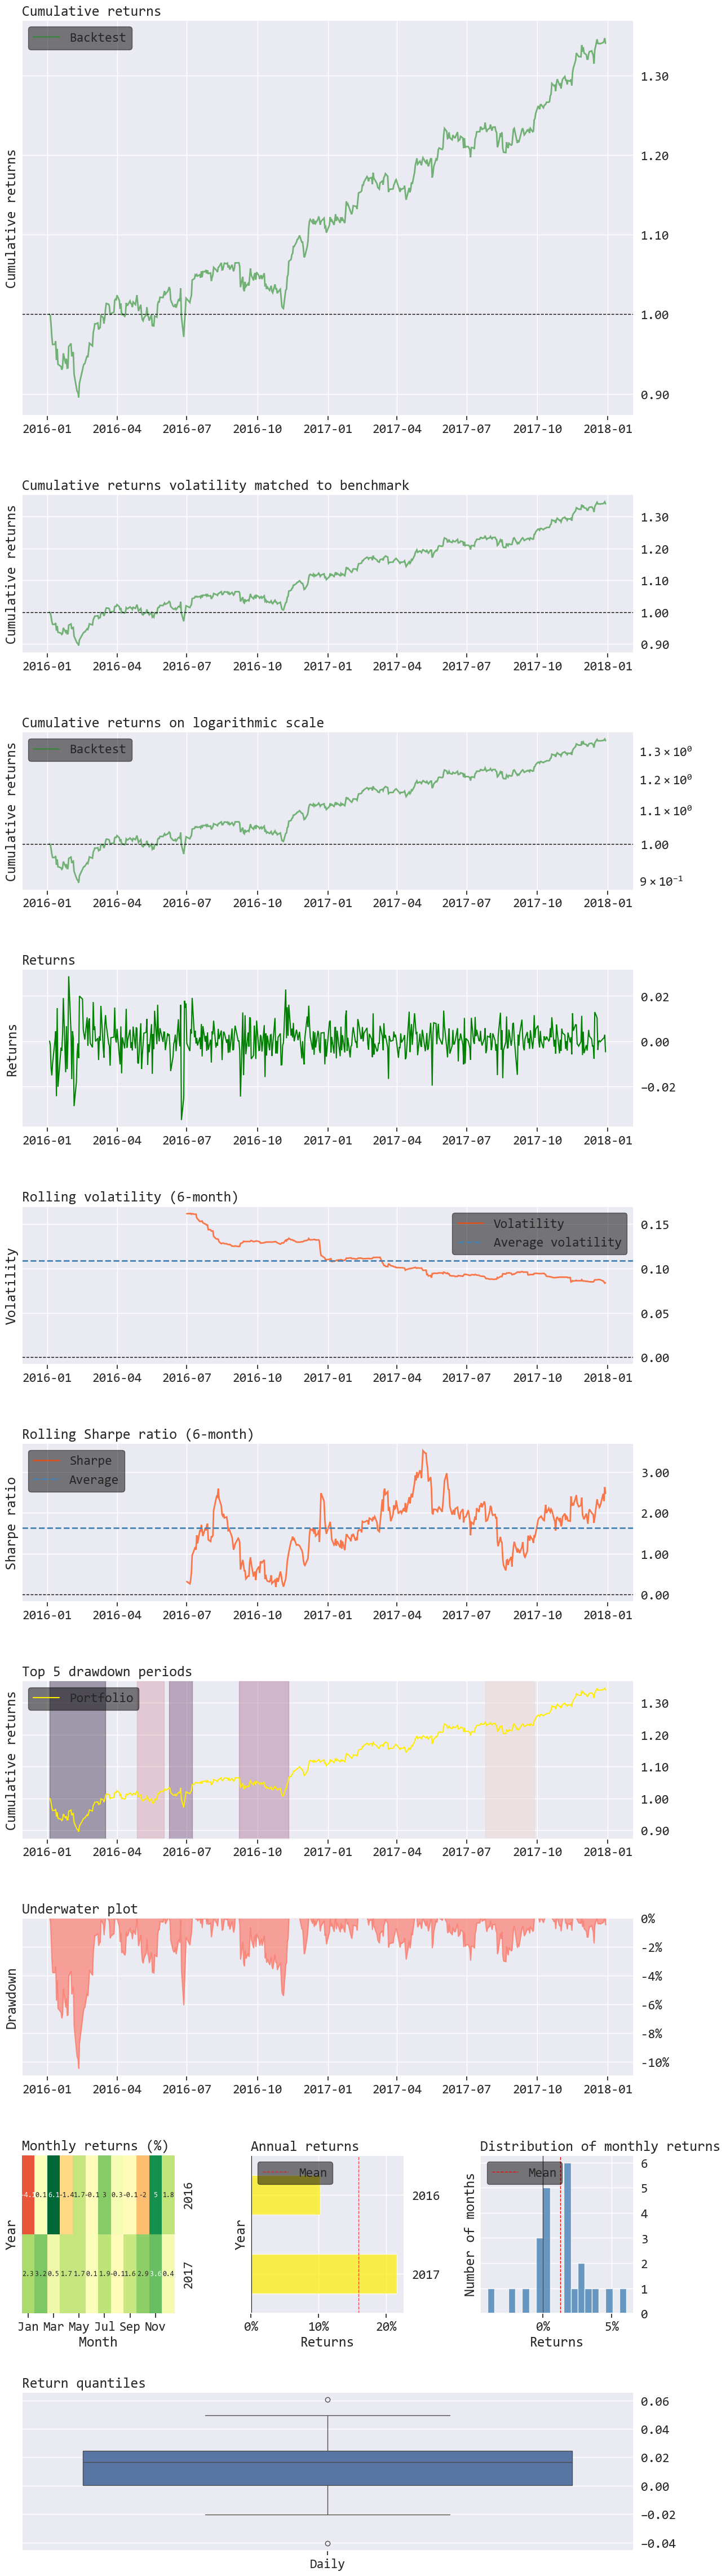

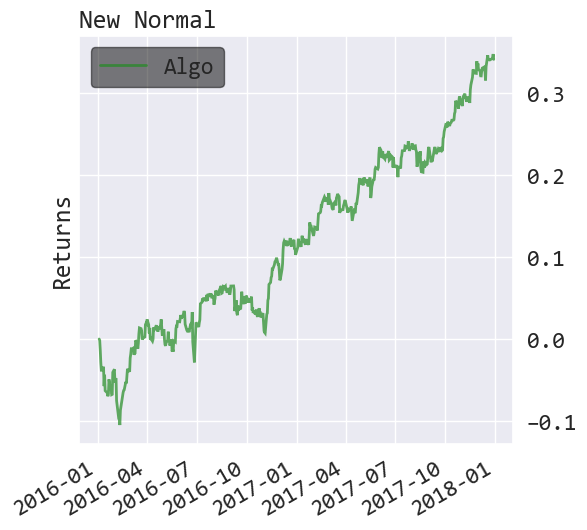

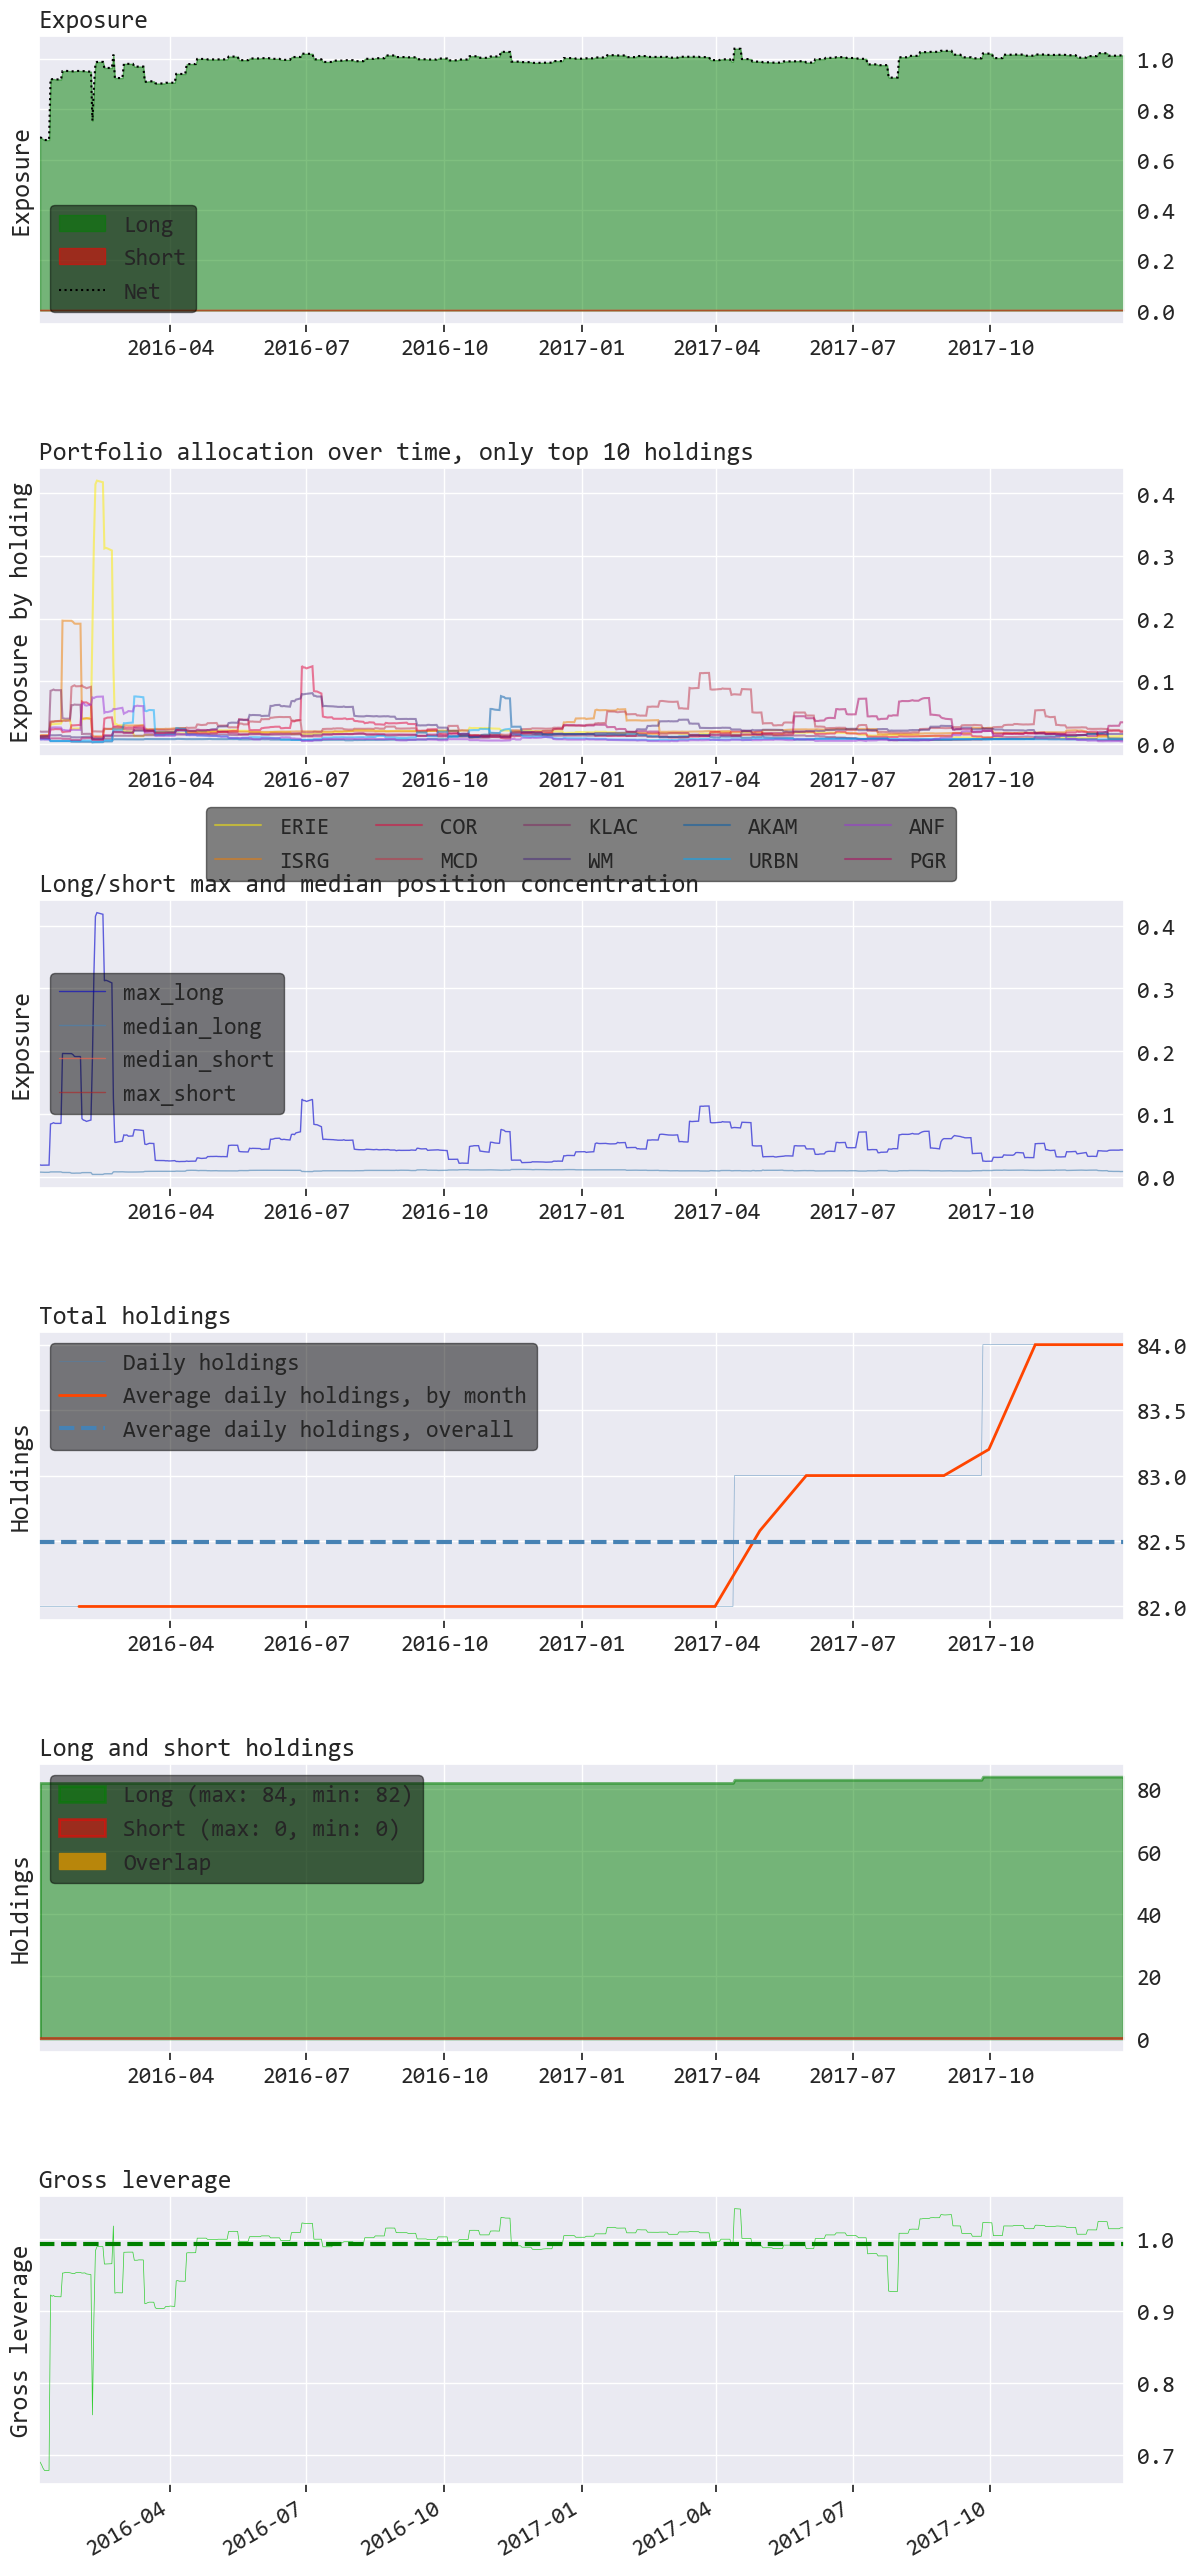

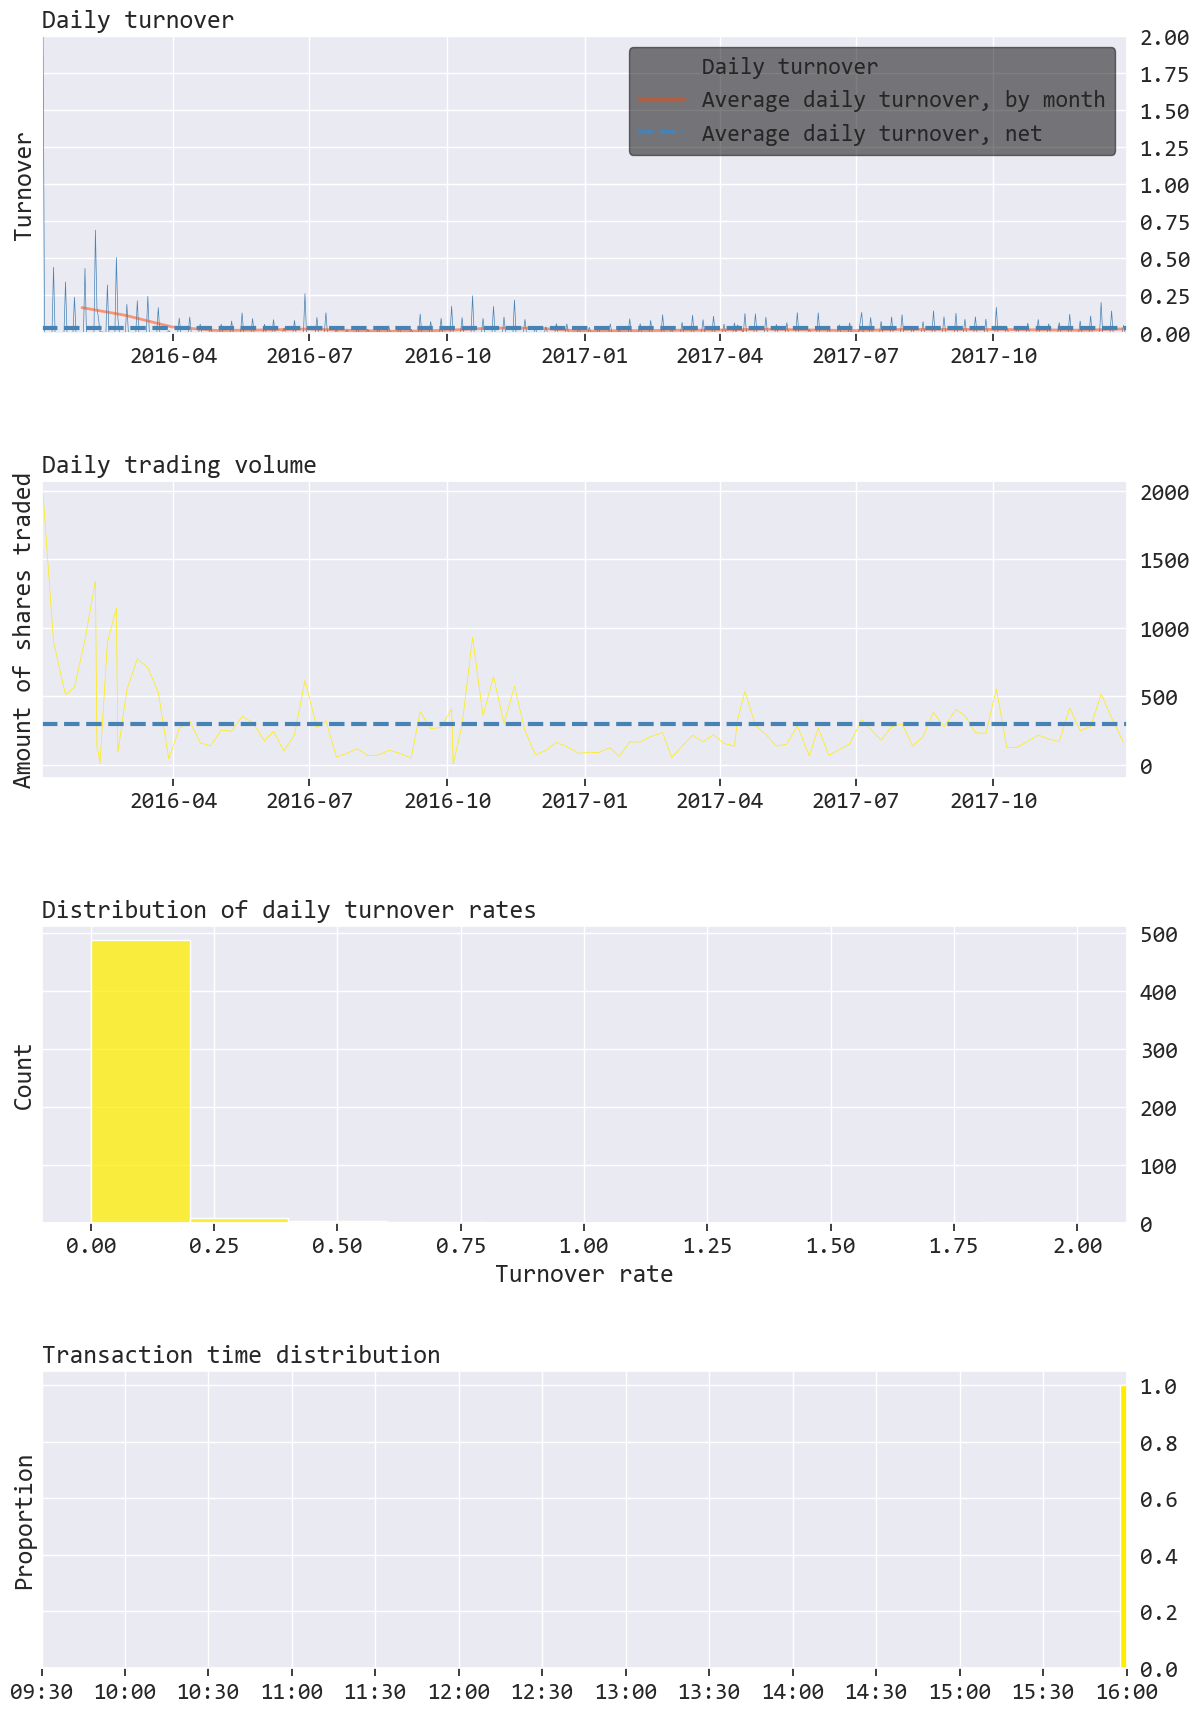

In [26]:
pf.create_full_tear_sheet(returns, positions, transactions)